## Time Series Analysis

series = trend + seasons + cycles + error


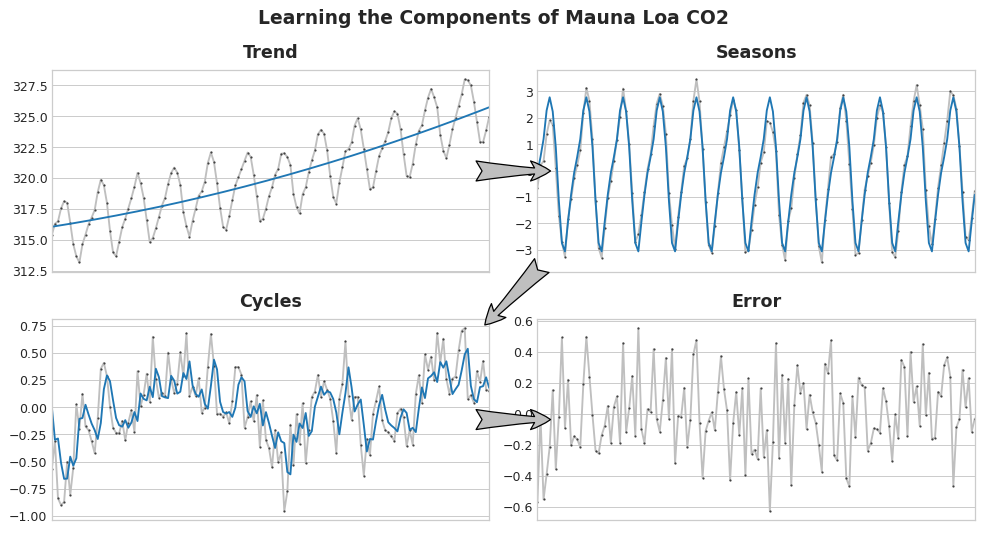

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv", index_col=0)

non_missing_df = df[df.values >0]
decomposed = seasonal_decompose(non_missing_df, period=12)
decomposed_df = pd.DataFrame(
    {"trend": decomposed.trend,
    "seasonality": decomposed.seasonal,
    "residual": decomposed.resid,
    "observation": decomposed.observed})

### Check Stationality, Linearity

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f00787d9810>,
      dtype=object)

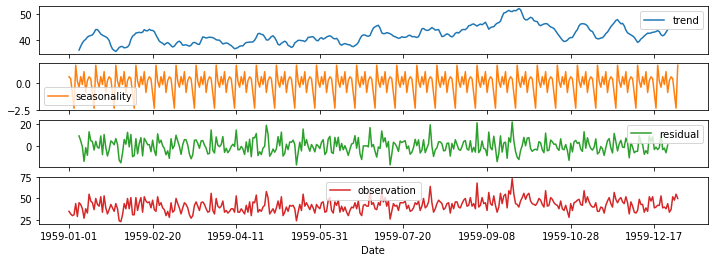

In [2]:
decomposed_df.plot(subplots=True, figsize=(12, 4))

Note: Autocorrelation is only describing the linear correlation, hence it's best to look at a lag plot (or use some more general measure of dependence, like mutual information) when choosing lag features. 

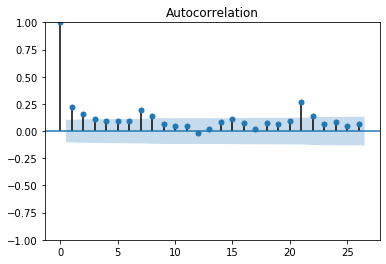

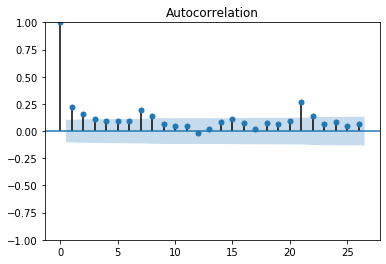

In [3]:
plot_acf(decomposed_df.observation) # 4lags

In [4]:
#plot_acf(decomposed_df.residual)

Residual has no autocorrelation = White noise 

In [5]:
import statsmodels.api as sm

# 単位根検定
adf_result = sm.tsa.stattools.adfuller(decomposed_df.residual[decomposed_df.residual.values > 0])
adf_result

(-13.717518726834243,
 1.2050537865985667e-25,
 0,
 165,
 {'1%': -3.470616369591229,
  '5%': -2.8792214018977655,
  '10%': -2.57619681359045},
 875.501544686394)

In [6]:
5.2434129901498554e-05 < 0.05

True

null hypothesis can be rejected, hence data is **stationary**

## Feature Engineering

- time-step features, lag features
- trend, seasonality(Seasonal indicators, Fourier Features and the Periodogram)

In [7]:
def make_lags(ts, lags):
    """
    ts: target feature
    lags: lag value deduced from the partial autocorrelation
    """
    
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


lag_df = make_lags(decomposed_df.observation, lags=4)
lag_df = lag_df.fillna(0.0)

df = pd.concat([decomposed_df, lag_df], axis=1)

### Trend

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

NameError: name 'tunnel' is not defined

The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

### Seasonality(https://www.kaggle.com/code/ryanholbrook/seasonality)

## ARIMA Modeling

ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

Example: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. 

In [116]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(X_train.observation, order=(4,1,2))
result = model.fit()
print(result.summary())

/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:            observation   No. Observations:                  317
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1066.423
Date:                Sat, 24 Sep 2022   AIC                           2146.847
Time:                        07:08:34   BIC                           2173.137
Sample:                    01-01-1959   HQIC                          2157.350
                         - 11-13-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8872      0.067    -13.287      0.000      -1.018      -0.756
ar.L2          0.1361      0.087      1.574      0.116      -0.033       0.306
ar.L3          0.0377      0.093      0.408      0.6

In [117]:
mean_squared_error(y_test, y_pred = result.predict(start=317, end=317+47), squared=False)

6.573937131145416

### Evaluation

In [ ]:
results = pd.DataFrame({"original": decomposed_df.observation[200:301], 
"predict": result.predict(start=200, end=300).values})
results.plot()

## VAR Models

In [9]:
from statsmodels.tsa.statespace.varmax import VARMAX
model = VARMAX(decomposed_df.observation, order= (2, 2),trend='c')

/srv/conda/envs/notebook/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


IndexError: tuple index out of range

## Prophet - Facebook

In [123]:
!conda install -c conda-forge prophet.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

In [127]:
df = pd.DataFrame({"ds": decomposed_df.index,
              "y": decomposed_df.observation.values})
df.set_index("ds")

,y
ds,
1959-01-01,35.0
1959-01-02,32.0
1959-01-03,30.0
1959-01-04,31.0
1959-01-05,44.0
...,...
1959-12-27,37.0
1959-12-28,52.0
1959-12-29,48.0


In [128]:
print(df.ds[121])
print(df.ds[242])
print(df.ds[364])

1959-05-02
1959-08-31
1959-12-31


In [129]:
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

cutoffs = pd.to_datetime(['1959-05-02', '1959-08-31'])


param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

ModuleNotFoundError: No module named 'prophet'

In [ ]:
model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=10.00)
model.fit(df)
model.predict().yhat.plot()

In [ ]:
pred[["yhat_lower", "yhat", "yhat_upper"]].plot()

In [ ]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(decomposed_df.observation[200:301].values, result.predict(start=200,end=300)))
print("The root mean squared error is {}.".format(rmse))

In [ ]:
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(non_missing_df)
anomaly = clf.predict(non_missing_df)
non_missing_df["anomaly"] = anomaly

## Hybrid Model

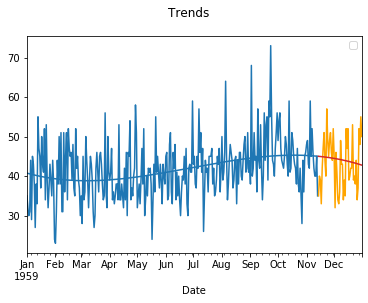

In [23]:
y = df.observation.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=3,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

X.index = pd.to_datetime(X.index)
y.index = pd.to_datetime(y.index)

# It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    #columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    #columns=y_test.columns,
)

# Plot
axs = y_train.plot( subplots=True, sharex=True)
axs = y_test.plot(color="orange", subplots=True, sharex=True, ax=axs)
axs = y_fit.squeeze().plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.squeeze().plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [10]:
#!pip install xgboost

In [24]:
X = df.iloc[:, 3:]
X.index = pd.to_datetime(X.index)

In [25]:
# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [30]:
y_fit

,0
Date,
1959-01-01,40.749525
1959-01-02,40.686264
1959-01-03,40.624200
1959-01-04,40.563325
1959-01-05,40.503632
...,...
1959-11-09,45.108019
1959-11-10,45.089554
1959-11-11,45.070174


In [42]:
from xgboost import XGBRegressor

# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.squeeze()#.stack()#.squeeze()    # trend from training set
y_pred = y_pred.squeeze()#.stack()#.squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

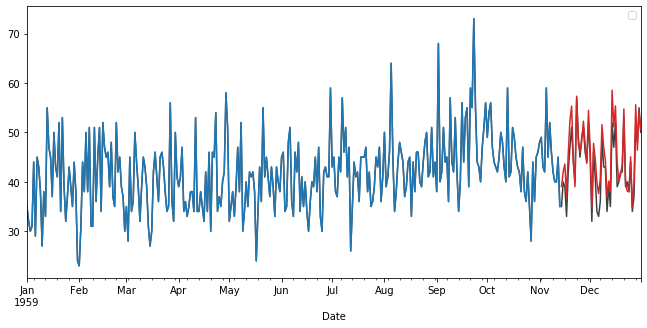

In [59]:

axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

In [15]:
#!pip install scikit-learn==0.23.2

In [56]:
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, y_fit_boosted, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_boosted, squared=False)

In [58]:
train_rmse
test_rmse

2.942350444764724

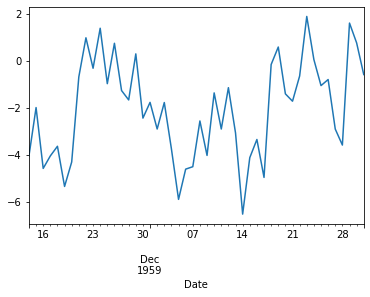

In [64]:
(y_test - y_pred_boosted).plot()